<a href="https://colab.research.google.com/github/paulhondola/paulhondola/blob/main/PI_Laborator_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Linear regression in PyTorch

To keep things simple, we will construct an artificial dataset
according to a linear model with additive noise.
Our task will be to recover this model's parameters
using the finite set of examples contained in our dataset.
We will keep the data low-dimensional so we can visualize it easily.
In the following code, we generate a dataset
containing $1000$ examples, each consisting of $2$ features
sampled from a standard normal distribution.
Thus, our synthetic dataset will be a matrix
$\boldsymbol{X}\in \mathbb{R}^{1000 \times 2}$.

The true parameters generating our dataset will be
$\boldsymbol{w} = [2, -3.4]^\top$ and $b = 4.2$,
and our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

$$\boldsymbol{y}= \boldsymbol{X} \boldsymbol{w} + b + \epsilon.$$

We can think of $\epsilon$ as capturing potential
measurement errors on the features and labels.
We will assume that the standard assumptions hold, and thus
that $\epsilon$ obeys a normal distribution with mean of $0$.
To make our problem easy, we will set its standard deviation to $0.01$.
The following code generates our synthetic dataset.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = X @ w + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

In [ ]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Note that each row in `features` consists of a $2$-dimensional data example,
and that each row in `labels` consists of a $1$-dimensional label value (a scalar).

In [ ]:
print('Features:', features[0], '\nLabel:', labels[0])

Features: tensor([1.9269, 1.4873]) 
Label: tensor([2.9871])


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.

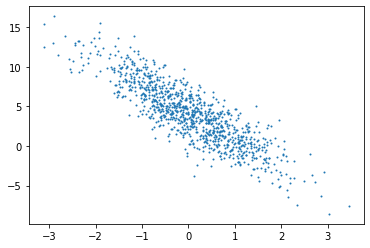

In [ ]:
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), s=1)
plt.show()

Recall that training models consists of
making multiple passes over the dataset,
fetching one mini-batch of examples at a time,
and using them to update our model.
Since this process is so fundamental
to training machine learning algorithms,
it is worth defining a utility function
to shuffle the dataset and access it in mini-batches.

In the following code, we define the `data_iter` function to demonstrate one possible implementation of this functionality.
The function takes a batch size, a matrix of features,
and a vector of labels, yielding mini-batches of the size `batch_size`.
Each mini-batch consists of a tuple of features and labels.

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In general, note that we want to use reasonably sized mini-batches
to take advantage of the GPU hardware,
which excels at parallelizing operations.
Because each example can be fed through our models in parallel,
and the gradient of the loss function for each example can also be taken in parallel,
GPUs allow us to process hundreds of examples in just little more time
than it might take to process a single example.

To build some intuition, let us read and print
the first small batch of data examples.
The shape of the features in each mini-batch tells us
both the mini-batch size and the number of input features.
Likewise, our mini-batch of labels will have a shape given by `batch_size`.


In [ ]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.1862, -1.2203],
        [ 0.1828,  0.6247],
        [ 0.3726, -1.9105],
        [ 1.2215, -0.3137],
        [ 0.2240, -0.7555],
        [ 0.3267, -0.8344],
        [-0.7585,  0.9420],
        [-1.5785,  0.6716],
        [ 0.9475,  0.4364],
        [-1.3793,  0.6258]]) 
 tensor([[10.7316],
        [ 2.4343],
        [11.4371],
        [ 7.7038],
        [ 7.2027],
        [ 7.7014],
        [-0.5214],
        [-1.2277],
        [ 4.6104],
        [-0.7060]])


As we run the iteration, we obtain distinct mini-batches
successively, until the entire dataset has been exhausted.
While the iteration implemented above is good for didactic purposes,
it is inefficient in ways that might get us in trouble on real problems.
For example, it requires that we load all the data in memory
and that we perform many random memory access.
The built-in iterators implemented in a deep learning framework
are considerably more efficient, and they can deal
with both data stored in files and data fed via data streams.

Rather writing our own iterator,
we can call upon the existing API in PyTorch to read the data. We pass in `features` and `labels` as arguments, and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).

In [ ]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [ ]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

Now, we can use `data_iter` in much the same way as we called
the `data_iter()` function above.
To verify that it is working, we can read and print
the first mini-batch of examples.
Comparing with the `data_iter()` function,
here we use `iter()` to construct a Python iterator, and use `next()` to obtain the first item from the iterator.

In [ ]:
next(iter(data_iter))

[tensor([[-1.0838, -0.3889],
         [ 0.3267, -0.8344],
         [ 1.5921, -0.4162],
         [ 1.7685, -0.9858],
         [ 1.9138,  0.3378],
         [ 1.2358, -2.0371],
         [ 0.3120,  0.7174],
         [ 0.0879, -1.2415],
         [-0.7150, -0.0476],
         [ 0.6719,  0.9852]]), tensor([[ 3.3636],
         [ 7.7014],
         [ 8.8059],
         [11.0980],
         [ 6.8769],
         [13.5980],
         [ 2.3910],
         [ 8.5881],
         [ 2.9337],
         [ 2.2025]])]

In order to implement **linear regression**, we can use PyTorch's predefined layers, which allow us to focus especially
on the layers used to construct the model,
rather than having to focus on the implementation.
We will first define a model variable `net`,
which will refer to an instance of the `nn.Sequential` class.
The `nn.Sequential` class defines a container
for several layers that will be chained together.
Given input data, a `nn.Sequential` instance passes it through
the first layer, in turn passing the output
as the second layer's input, and so forth.
In the following example, our model consists of only one layer,
so we do not really need `nn.Sequential`.
But, since nearly all of our future models
will involve multiple layers,
we will use it anyway, just to get familiarized with the most standard workflow.

Recall that we redefined linear regression as a single-layer neural network.
The layer is said to be *fully-connected*,
because each of its inputs is connected to each of its outputs
by means of a matrix-vector multiplication.

In PyTorch, the fully-connected layer is defined in the `nn.Linear` class. Note that we pass two arguments into `nn.Linear`. The first one specifies the input feature dimension, which is $2$, and the second one is the output feature dimension, which is a single scalar, and therefore $1$.

In [ ]:
# `nn` is an abbreviation for neural networks
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

Before using `net`, we need to initialize the model parameters,
such as the weights and bias in the linear regression model.
Deep learning frameworks often have a predefined way to initialize the parameters.
Here, we specify that each weight parameter
should be randomly sampled from a normal distribution
with mean $0$ and standard deviation $0.01$.
The bias parameter will be initialized to $0$.

As we have specified the input and output dimensions when constructing `nn.Linear`,
now we can access the parameters directly, to specify their initial values.
We first locate the layer by `net[0]`, which is the first layer in the network,
and then use the `weight.data` and `bias.data` attributes to access the parameters.
Next, we use the replace methods `normal_()` and `fill_()` to overwrite parameter values. In PyTorch, methods that end with `_` do the corresponding operation in place.

In [ ]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

The `nn.MSELoss` class computes the *mean squared error* (without the $1/2$ factor).
By default, it returns the average loss over examples.


In [ ]:
loss = nn.MSELoss()

Mini-batch stochastic gradient descent is a standard tool
for optimizing neural networks,
and thus PyTorch supports it, alongside a number of
variations of this algorithm, in the `optim` module.
When we instantiate an `SGD` instance, we will specify the parameters to optimize over
(obtainable from our `net` via `net.parameters()`), with a dictionary of hyperparameters
required by our optimization algorithm.
Mini-batch stochastic gradient descent just requires that
we set the value `lr`, which is set to $0.03$ here.

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.03)

Expressing our model through
high-level APIs of a deep learning framework
requires relatively few lines of code.
We do not have to individually allocate parameters,
define our loss function, or implement mini-batch stochastic gradient descent.
Once we start working with much more complex models,
advantages of high-level APIs will grow considerably.

Now, all we have left to do is define the training loop: for some number of epochs,
we will make a complete pass over the dataset (`data_iter`),
iteratively fetching one mini-batch of inputs
and the corresponding ground-truth labels.
For each mini-batch, we go through the following steps:

* Generate predictions by calling `net(X)` and calculate the loss `l` between the predictions and the labels `y` (the *forward propagation*).
* Calculate gradients by running the *backpropagation*, using the `backward()` function on the loss. To prevent PyTorch from accumulating gradients, which it does by default, we have to call the `zero_grad()` function on the optimizer, before the call to `backward()`.
* Update the model parameters by invoking our *optimizer*, using the `step()` function on the optimizer.

We compute the loss after each epoch and print it to monitor progress.

In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    l = loss(net(features), labels)
    print(f'Epoch {epoch + 1}, Loss {l:f}')

Epoch 1, Loss 0.000353
Epoch 2, Loss 0.000103
Epoch 3, Loss 0.000101


Below, we compare the model parameters learned by training on finite data
and the actual parameters that generated our dataset.
To access parameters,
we first access the layer that we need from `net`,
and then access that layer's weights and bias.
Note that our estimated parameters are
close to their ground-truth counterparts.


In [ ]:
w = net[0].weight.data
print('Error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('Error in estimating b:', true_b - b)

Error in estimating w: tensor([-0.0002,  0.0008])
Error in estimating b: tensor([-0.0007])


#The FashionMNIST dataset

One of the most widely used datasets for image classification is the  MNIST dataset.
While it had a good history as a benchmark dataset,
even simple models by today's standards achieve classification accuracy over $95\%$ on it,
making it unsuitable for distinguishing between stronger models and weaker ones.
Today, MNIST serves as more of a sanity check than as a benchmark.
Thus, we will focus our discussion in the following
on the qualitatively similar, but comparatively more complex Fashion-MNIST
dataset, which was released in 2017.

We can download and read the Fashion-MNIST dataset into memory via the build-in functions in PyTorch.

In [ ]:
import torchvision
from torchvision import transforms

# `ToTensor()` converts the image data from PIL type to 32-bit floating point
# tensors. It also divides all numbers by 255, so that all pixel values are between
# 0 and 1
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Fashion-MNIST consists of images from $10$ categories, each represented
by $6000$ images in the training dataset and by $1000$ in the test dataset.
The *test dataset* (or *test set*) is used for evaluating  model performance and not for training.
Consequently, the training set and the test set
contain $60000$ and $10000$ images, respectively.

In [ ]:
len(mnist_train), len(mnist_test)

(60000, 10000)

The height and width of each input image are both $28$ pixels.
Note that the dataset consists of grayscale images, whose number of channels is $1$.
For brevity, we store the shape of any image with a height of $h$ pixels and a width of $w$ pixels as $h \times w$ or ($h$, $w$).

In [ ]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

The images in Fashion-MNIST are associated with the following categories:
t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot.
The following function converts between numeric label indices and their names in text.

In [ ]:
def get_fashion_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

We can now create a function to visualize these examples.

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    plt.tight_layout()
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

Here are the images and their corresponding labels (in text)
for the first few examples in the training dataset.

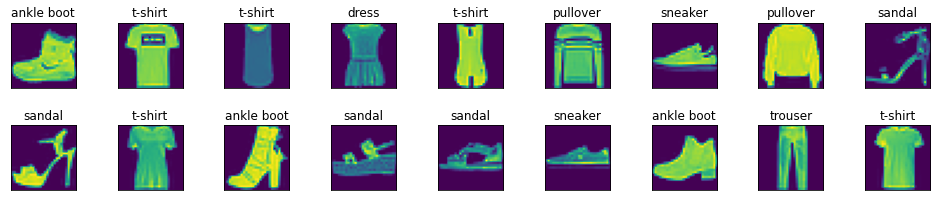

In [ ]:
X, y = next(iter(torch.utils.data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

To make our life easier when reading from the training and test sets,
we use the built-in data iterator, rather than creating one from scratch.
Recall that, at each iteration, a data iterator
reads a mini-batch of data with size `batch_size` each time.
We also randomly shuffle the examples for the training data iterator.

In [ ]:
batch_size = 256

# Use 2 processes to read the data.
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=2)

Now we define the `load_data_fashion_mnist()` function
that obtains and reads the Fashion-MNIST dataset.
It returns the data iterators for the training set, the validation set, and the test set. It uses the `random_split()` method to split the initial training set into the actual training set, having `50000` instances, and the validation set, having the remaining `10000` instances. In order to ensure reproducibility, we also specify a generator with a fixed seed. In addition, the `load_data_fashion_mnist()` function accepts an optional argument to resize images to another shape.

In [ ]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

Below, we test the image resizing feature of the `load_data_fashion_mnist()` function
by specifying the `resize` argument.

In [ ]:
train_iter, val_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


We are now ready to work with the Fashion-MNIST dataset.

#Softmax regression in PyTorch

Next, we will implement **softmax regression** in PyTorch. We will work with the Fashion-MNIST dataset, setting up data iterators with batch size $256$.

In [ ]:
batch_size = 256
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)

As for linear regression,
each example here will be represented by a fixed-length vector.
Each example in the raw dataset is a $28 \times 28$ image.
Here, we will flatten each image,
treating them as vectors of length $784$.
Thus, we treat each pixel location as just another feature.

Recall that, in softmax regression,
we have as many outputs as there are classes.
Because our dataset has $10$ classes,
our network will have an output dimension of $10$.
Consequently, our weights will constitute a $784 \times 10$ matrix,
and the biases will constitute a $1 \times 10$ row vector.

Recall also that the output layer of softmax regression
is a fully-connected layer. Therefore, to implement our model,
we just need to add one fully-connected layer
with $10$ outputs to a `nn.Sequential` class.
Because the inputs are given in the dataset as a $3$-dimensional tensor, we have to reshape them to a $2$-dimensional tensor, which is the only type of tensor fully-connected layers can manipulate. We do this by adding the `nn.Flatten` layer before the fully-connected layer.

Again, we initialize the weights at random
with zero mean and standard deviation $0.01$.

In [ ]:
# PyTorch does not implicitly reshape the inputs. Thus, we define the flatten
# layer to reshape the inputs before the linear layer in our network.
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

Notice that we do not add a softmax layer to our network. In PyTorch, instead of passing softmax probabilities into the loss function, we will just
pass the logits, and compute the softmax and its logarithm
all at once inside the *cross-entropy loss* function,
which uses different computational tricks to avoid numerical instability issues.

In [ ]:
loss = nn.CrossEntropyLoss()

Here, we use mini-batch stochastic gradient descent
with a learning rate of $0.1$ as the optimization algorithm.
Note that this is the same as we applied in the linear regression example,
and it illustrates the general applicability of the optimizers.

In [ ]:
lr = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

Given the predicted probability distribution `y_hat`,
we typically choose the class with the highest predicted probability,
whenever we must output a hard prediction.
Indeed, many applications require that we make a choice.
Gmail must categorize an email into "Primary", "Social", "Updates", or "Forums".
It might estimate probabilities internally,
but, at the end of the day, it has to choose one among the classes.

When predictions are consistent with the label class `y`, they are correct.
The classification accuracy is the fraction of all predictions that are correct.
Although it can be difficult to optimize accuracy directly (it is not differentiable),
it is often the performance measure that we care most about,
and we will nearly always report it when training classifiers.

To compute accuracy we do the following.
First, if `y_hat` is a matrix,
we assume that the second dimension stores prediction scores for each class.
We use `argmax()` to obtain the predicted class by the index for the largest entry in each row.
Then, we compare the predicted class with the ground-truth `y` elementwise.
Since the equality operator `==` is sensitive to data types,
we convert `y_hat`'s data type to match that of `y`.
The result is a tensor containing entries of $0$ (false) and $1$ (true).
Taking the sum yields the number of correct predictions. We can evaluate the accuracy for any model `net` on a dataset that is accessed via the data iterator `data_iter`. We use the variables `total_hits` and `total_samples` for storing the number of correct predictions and the number of predictions, respectively. Both will be accumulated over time as we iterate over the dataset. We also accumulate the total loss in the `total_loss` variable, and we return the mean loss by dividing by the number of batches `len(data_iter)`, because each individual loss is computed batchwise.

In [ ]:
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

The training loop for softmax regression should look strikingly familiar,
if we read through our implementation
of linear regression.
Here, we refactor the implementation to make it reusable.
First, we define a function to train for one epoch.
Note that `optimizer` is a general function to update the model parameters,
which accepts the batch size as an argument.
It will be one of the framework's built-in optimization functions.

In [ ]:
def train_epoch(net, train_iter, loss, optimizer):
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

The following training function then
trains a model `net` on a training dataset accessed via `train_iter`
for multiple epochs, which is specified by `num_epochs`.
At the end of each epoch,
the model is evaluated on a validation dataset, accessed via `val_iter`.

In [ ]:
def train(net, train_iter, val_iter, loss, num_epochs, optimizer):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

Now, we train the model for $10$ epochs.
Note that both the number of epochs (`num_epochs`),
and learning rate (`lr`) are adjustable hyperparameters.
By changing their values, we may be able
to increase the classification accuracy of the model.

In [ ]:
num_epochs = 10
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

Epoch 1, Train loss 0.82, Train accuracy 73.86, Validation loss 0.63, Validation accuracy 78.73
Epoch 2, Train loss 0.58, Train accuracy 80.99, Validation loss 0.57, Validation accuracy 81.14
Epoch 3, Train loss 0.54, Train accuracy 82.23, Validation loss 0.53, Validation accuracy 82.20
Epoch 4, Train loss 0.51, Train accuracy 82.91, Validation loss 0.52, Validation accuracy 82.29
Epoch 5, Train loss 0.49, Train accuracy 83.39, Validation loss 0.51, Validation accuracy 82.79
Epoch 6, Train loss 0.48, Train accuracy 83.79, Validation loss 0.49, Validation accuracy 83.34
Epoch 7, Train loss 0.47, Train accuracy 84.01, Validation loss 0.51, Validation accuracy 82.04
Epoch 8, Train loss 0.46, Train accuracy 84.24, Validation loss 0.47, Validation accuracy 83.80
Epoch 9, Train loss 0.46, Train accuracy 84.63, Validation loss 0.49, Validation accuracy 83.52
Epoch 10, Train loss 0.45, Train accuracy 84.59, Validation loss 0.53, Validation accuracy 80.71


We separately plot the loss and the accuracy for the training and validation sets, using the `plot_loss()` and `plot_accuracy()` methods, respectively.

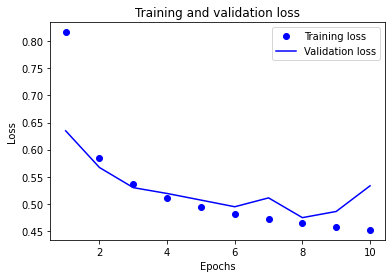

In [ ]:
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1)
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(train_loss_all, val_loss_all)

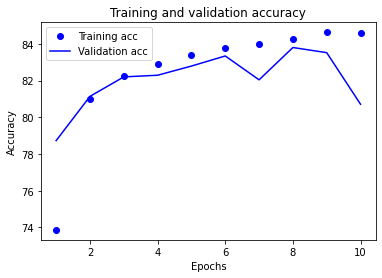

In [ ]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(train_acc_all, val_acc_all)

Now that training is complete, we can evaluate the trained model on the *test set*, which was not used at all during the training process, not even for choosing hyperparameters.

In [ ]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss 0.55, Test accuracy 80.06


We can also use our model to classify some images.
Given a series of images,
we will compare their actual labels
(first line of text output)
and the predictions from the model
(second line of text output).

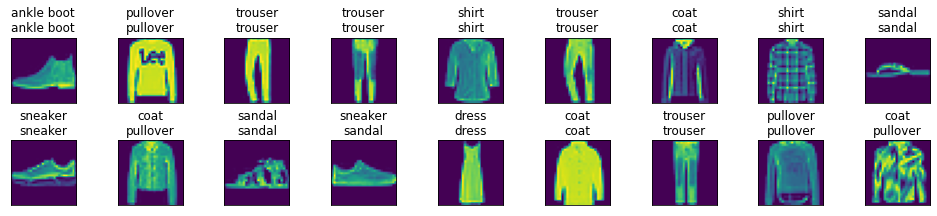

In [ ]:
def predict(net, test_iter, n=18):
    """Predict labels."""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 2, int(n/2), titles=titles[0:n])

predict(net, test_iter)

#Multilayer perceptrons

As compared with our implementation
of softmax regression,
the only difference is that we add
*two* fully-connected layers
(previously, we added *one*).
The first is our *hidden layer*,
which contains $256$ hidden units,
and applies the ReLU activation function.
The second is our *output layer*.

In [ ]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

The training loop is exactly the same
as when we implemented softmax regression.
This modularity enables us to separate
matters concerning the model architecture
from other considerations.

In [ ]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

Epoch 1, Train loss 1.11, Train accuracy 60.82, Validation loss 0.78, Validation accuracy 71.11
Epoch 2, Train loss 0.63, Train accuracy 77.49, Validation loss 0.72, Validation accuracy 71.26
Epoch 3, Train loss 0.54, Train accuracy 81.07, Validation loss 0.53, Validation accuracy 80.94
Epoch 4, Train loss 0.50, Train accuracy 82.43, Validation loss 0.48, Validation accuracy 83.58
Epoch 5, Train loss 0.47, Train accuracy 83.48, Validation loss 0.51, Validation accuracy 80.87
Epoch 6, Train loss 0.45, Train accuracy 84.05, Validation loss 0.45, Validation accuracy 84.12
Epoch 7, Train loss 0.43, Train accuracy 84.69, Validation loss 0.47, Validation accuracy 82.92
Epoch 8, Train loss 0.42, Train accuracy 85.19, Validation loss 0.46, Validation accuracy 82.82
Epoch 9, Train loss 0.41, Train accuracy 85.65, Validation loss 0.47, Validation accuracy 83.84
Epoch 10, Train loss 0.40, Train accuracy 85.97, Validation loss 0.46, Validation accuracy 82.57


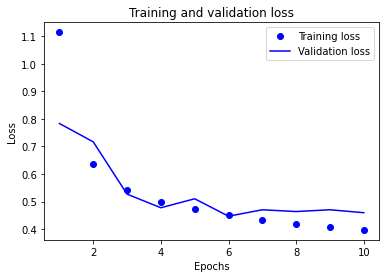

In [ ]:
plot_loss(train_loss_all, val_loss_all)

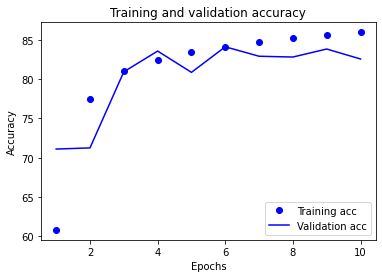

In [ ]:
plot_accuracy(train_acc_all, val_acc_all)

In [ ]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss 0.49, Test accuracy 81.66


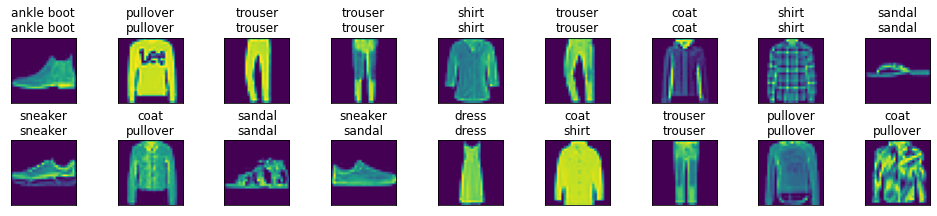

In [ ]:
predict(net, test_iter)

#Weight decay

Because weight decay is ubiquitous
in neural network optimization,
the deep learning framework makes it especially convenient,
integrating weight decay into the optimization algorithm itself,
for easy use in combination with any loss function.
Moreover, this integration serves a computational benefit,
allowing implementation tricks to add weight decay to the algorithm,
without any additional computational overhead.
Since the weight decay portion of the update
depends only on the current value of each parameter,
the optimizer must touch each parameter once anyway.

In the following code, we specify
the weight decay hyperparameter directly
through `weight_decay`, when instantiating our optimizer.
By default, PyTorch decays both
weights and biases simultaneously.


In [ ]:
wd = 0.001
optimizer = torch.optim.SGD(net.parameters(), weight_decay=wd, lr=lr)

Since we do not change the network architecture at all, `net` will be the same as before. However, in order to train the network from scratch, we call the `net.apply(init_weights)` method to reinitialize the weights randomly.

Note that the training error increases,
but the test error decreases.
This is precisely the effect
we expect from regularization.

In [ ]:
net.apply(init_weights)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

Epoch 1, Train loss 1.07, Train accuracy 64.67, Validation loss 0.68, Validation accuracy 75.22
Epoch 2, Train loss 0.62, Train accuracy 77.99, Validation loss 0.59, Validation accuracy 79.13
Epoch 3, Train loss 0.54, Train accuracy 81.09, Validation loss 0.55, Validation accuracy 80.00
Epoch 4, Train loss 0.50, Train accuracy 82.45, Validation loss 0.63, Validation accuracy 76.94
Epoch 5, Train loss 0.48, Train accuracy 83.14, Validation loss 0.48, Validation accuracy 82.92
Epoch 6, Train loss 0.46, Train accuracy 83.96, Validation loss 0.49, Validation accuracy 82.36
Epoch 7, Train loss 0.44, Train accuracy 84.65, Validation loss 0.57, Validation accuracy 79.18
Epoch 8, Train loss 0.43, Train accuracy 84.99, Validation loss 0.43, Validation accuracy 84.82
Epoch 9, Train loss 0.42, Train accuracy 85.32, Validation loss 0.43, Validation accuracy 84.59
Epoch 10, Train loss 0.41, Train accuracy 85.58, Validation loss 0.43, Validation accuracy 84.97


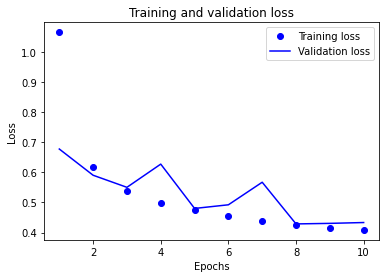

In [ ]:
plot_loss(train_loss_all, val_loss_all)

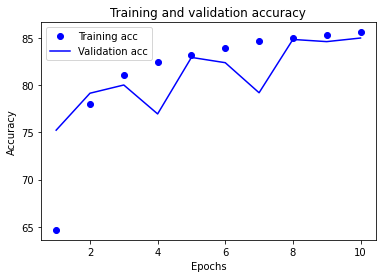

In [ ]:
plot_accuracy(train_acc_all, val_acc_all)

In [ ]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss 0.45, Test accuracy 84.04


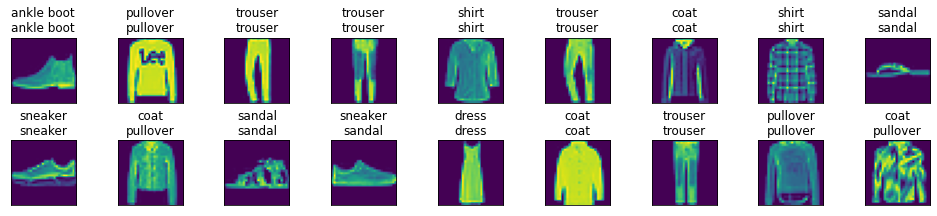

In [ ]:
predict(net, test_iter)

#Dropout

With high-level APIs, all we need to do is add a `nn.Dropout` layer
after each fully-connected layer,
passing in the dropout probability
as the only argument to its constructor.
During training, the `nn.Dropout` layer will randomly
drop out outputs of the previous layer
(or equivalently, the inputs to the subsequent layer)
according to the specified dropout probability. Here, we will drop $20\%$ of the outputs of the first hidden layer, and $30\%$ of the outputs of the second hidden layer.
When not in training mode,
the `nn.Dropout` layer simply passes the data through, during testing.

In [ ]:
dropout1, dropout2 = 0.2, 0.3

net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.3, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

Next, we train and test the model.

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

Epoch 1, Train loss 1.85, Train accuracy 32.99, Validation loss 1.16, Validation accuracy 55.63
Epoch 2, Train loss 0.96, Train accuracy 63.20, Validation loss 0.88, Validation accuracy 67.85
Epoch 3, Train loss 0.74, Train accuracy 72.76, Validation loss 0.65, Validation accuracy 73.83
Epoch 4, Train loss 0.63, Train accuracy 76.85, Validation loss 0.59, Validation accuracy 78.13
Epoch 5, Train loss 0.57, Train accuracy 79.66, Validation loss 0.59, Validation accuracy 77.96
Epoch 6, Train loss 0.52, Train accuracy 81.45, Validation loss 0.49, Validation accuracy 82.44
Epoch 7, Train loss 0.49, Train accuracy 82.51, Validation loss 0.52, Validation accuracy 80.65
Epoch 8, Train loss 0.46, Train accuracy 83.41, Validation loss 0.46, Validation accuracy 83.86
Epoch 9, Train loss 0.45, Train accuracy 83.98, Validation loss 0.46, Validation accuracy 83.41
Epoch 10, Train loss 0.43, Train accuracy 84.69, Validation loss 0.41, Validation accuracy 85.15


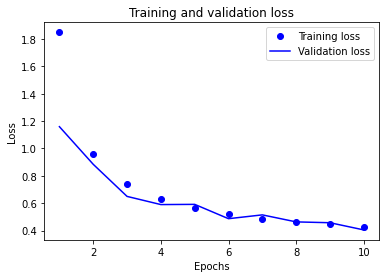

In [ ]:
plot_loss(train_loss_all, val_loss_all)

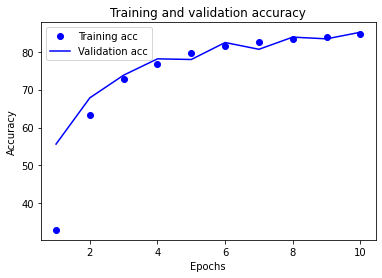

In [ ]:
plot_accuracy(train_acc_all, val_acc_all)

In [ ]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss 0.43, Test accuracy 84.50


#Deep learning computation

To implement complex neural networks,
we introduce the concept of a neural network *block*.
A block could describe a single layer,
a component consisting of multiple layers,
or the entire model itself.
One benefit of working with the block abstraction
is that they can be combined into larger artifacts,
often recursively. By defining code to generate blocks
of arbitrary complexity on demand,
we can write surprisingly compact code
and still implement complex neural networks.

From a programing standpoint, a block is represented by a *class*.
Any subclass of it must define a forward propagation function
that transforms its input into output
and must store any necessary parameters.
Note that some blocks do not require any parameters at all.
Finally, a block must possess a backpropagation function,
for the purpose of calculating gradients.
Fortunately, due to the auto differentiation mechanism,
when defining our own block,
we only need to worry about parameters
and the forward propagation function.

To begin, we revisit the code
that we used to implement MLPs.
The following code generates a network
with one fully-connected hidden layer
with $256$ units and ReLU activation,
followed by a fully-connected output layer
with $10$ units (no activation function).

In [ ]:
net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X)

tensor([[-0.1579, -0.0943,  0.0124,  0.1891, -0.1403, -0.1019, -0.0786, -0.0557,
          0.0037,  0.0181],
        [-0.3073, -0.1518, -0.0133,  0.1620, -0.1410, -0.1415,  0.0554,  0.0403,
          0.0132,  0.0318]], grad_fn=<AddmmBackward0>)

In this example, we constructed
our model by instantiating an `nn.Sequential`, with layers in the order
that they should be executed, passed as arguments.
In short, `nn.Sequential` defines a special kind of `nn.Module`,
the class that represents a block in PyTorch.
It maintains an ordered list of constituent `nn.Module`s.
Note that each of the two fully-connected layers is an instance of the `nn.Linear` class, which is itself a subclass of `nn.Module`.
The forward propagation (`forward()`) function is also remarkably simple:
it chains each block in the list together,
passing the output of each as the input to the next.
Note that, until now, we have been invoking our models
via the construction `net(X)` to obtain their outputs.
This is actually just shorthand for `net.__call__(X)`.

Perhaps the easiest way to develop intuition
about how a block works
is to implement one ourselves.
Before we implement our own custom block,
we briefly summarize the basic functionality
that each block must provide:

1. Ingest input data as arguments to its forward propagation function.
1. Generate an output by having the forward propagation function return a value. Note that the output may have a different shape from the input. For example, the first fully-connected layer in our model above ingests an input of dimension $20$, but returns an output of dimension $256$.
1. Calculate the gradient of its output with respect to its input, which can be accessed via its backpropagation function. Typically, this happens automatically.
1. Store and provide access to those parameters necessary
   to execute the forward propagation computation.
1. Initialize model parameters as needed.

In the following,
we code a block from scratch
corresponding to an MLP
with one hidden layer with $256$ hidden units,
and a $10$-dimensional output layer.
Note that the `MLP` class below inherits the class that represents a block.
We will heavily rely on the parent class's functions,
supplying only our own constructor (the `__init__` function in Python) and the forward propagation function.

In [ ]:
class MLP(nn.Module):
    # Declare a layer with model parameters. Here, we declare two fully
    # connected layers
    def __init__(self):
        # Call the constructor of the `MLP` parent class `nn.Module` to perform
        # the necessary initialization. In this way, other function arguments
        # can also be specified during class instantiation, such as the model
        # parameters
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # Hidden layer
        self.out = nn.Linear(256, 10)  # Output layer

    # Define the forward propagation of the model, that is, how to return the
    # required model output, based on the input `X`
    def forward(self, X):
        # Note here we use the nn.ReLU class for the ReLU activation function
        return self.out(nn.ReLU()(self.hidden(X)))

Let us first focus on the forward propagation function.
Note that it takes `X` as the input,
calculates the hidden representation
with the activation function applied,
and outputs its logits.
In this `MLP` implementation,
both layers are instance variables.
To see why this is reasonable, imagine
instantiating two MLPs, `net1` and `net2`,
and training them on different data.
Naturally, we would expect them
to represent two different learned models.

We instantiate the MLP's layers
in the constructor
and subsequently invoke these layers
on each call to the forward propagation function.
Note a few key details.
First, our customized `__init__` function
invokes the parent class's `__init__` function
via `super().__init__()`,
sparing us of restating code applicable to most blocks.
We then instantiate our two fully-connected layers,
assigning them to `self.hidden` and `self.out`.
Note that, unless we implement a new operator,
we need not worry about the backpropagation function
or parameter initialization.
The system will generate these functions automatically.
Let us try this out.

In [ ]:
net = MLP()
net(X)

tensor([[-0.1307, -0.0178,  0.0218, -0.0107,  0.0891, -0.0091,  0.0330, -0.3037,
         -0.0565,  0.0930],
        [-0.1456, -0.0841, -0.1539, -0.0173,  0.0479,  0.0281, -0.0687, -0.4378,
         -0.0381,  0.0290]], grad_fn=<AddmmBackward0>)

A key virtue of the block abstraction is its versatility.
We can subclass a block to create layers
(such as the fully-connected layer class),
entire models (such as the `MLP` class above),
or various components of intermediate complexity.
We exploit this versatility
throughout the following laboratories,
such as when addressing
convolutional neural networks.

We can now take a closer look
at how the `nn.Sequential` class works.
Recall that `nn.Sequential` was designed
to chain other blocks together one after the other.
To build our own simplified `MySequential`,
we just need to define two key functions:
1. A function to append blocks one by one to a list.
2. A forward propagation function to pass an input through the chain of blocks, in the same order as they were appended.

The following `MySequential` class delivers the same
functionality as the default `nn.Sequential` class.

In [ ]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # Here, `module` is an instance of a `nn.Module` subclass. We save it
            # in the member variable `_modules` of the `nn.Module` class, and its
            # type is OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict guarantees that members will be traversed in the order
        # they were added
        for block in self._modules.values():
            X = block(X)
        return X

In the `__init__` method, we add every module
to the ordered dictionary `_modules` one by one.
We might wonder why every `nn.Module`
possesses a `_modules` attribute
and why we used it, rather than just
defining a Python list ourselves.
In short, the main advantage of `_modules`
is that, during our module's parameter initialization,
the system knows to look inside the `_modules`
dictionary to find sub-modules whose
parameters also need to be initialized.

When our `MySequential`'s forward propagation function is invoked,
each added block is executed
in the order in which they were added.
We can now reimplement an MLP
using our `MySequential` class.

In [ ]:
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[ 0.0939,  0.1545, -0.0071, -0.1948,  0.1597,  0.0874, -0.1568, -0.0420,
         -0.0031,  0.0986],
        [ 0.0789,  0.2505,  0.0396, -0.1527,  0.1395,  0.0078, -0.0830, -0.0367,
         -0.0409,  0.2228]], grad_fn=<AddmmBackward0>)

Note that this use of `MySequential`
is identical to the code we previously wrote
for the `nn.Sequential` class.

The `nn.Sequential` class makes model construction easy,
allowing us to assemble new architectures
without having to define our own class.
However, not all architectures are simple chains of layers.
When greater flexibility is required,
we will want to define our own blocks.
For example, we might want to execute
Python's control flow within the forward propagation function.
Moreover, we might want to perform
arbitrary mathematical operations,
not simply relying on predefined neural network layers. Thus, we can integrate
arbitrary code into the flow of our
neural network computations.

Once we have chosen an architecture
and set our hyperparameters,
we proceed to the training loop,
where our goal is to find parameter values
that minimize our loss function.
After training, we will need these parameters
in order to make future predictions.
Additionally, we will sometimes wish
to extract the parameters
either to reuse them in some other context,
to save our model to disk so that
it may be executed in other software,
or for examination in the hope of
gaining scientific understanding.

Most of the time, we will be able
to ignore the details
of how parameters are declared
and manipulated, relying on deep learning frameworks
to do the heavy lifting.
However, when we move away from
stacked architectures with standard layers,
we will sometimes need to get into the details
of declaring and manipulating parameters.

We start by focusing on an MLP with one hidden layer.

In [ ]:
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.0645],
        [-0.1182]], grad_fn=<AddmmBackward0>)

Let us start with how to access parameters
from the models that we already know.
When a model is defined via the `nn.Sequential` class,
we can first access any layer by indexing
into the model as though it were a list.
Each layer's parameters are conveniently
located in its attribute.
We can inspect the parameters of the second fully-connected layer as follows.

In [ ]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.2857, -0.0471, -0.0795, -0.0915, -0.0041,  0.1522, -0.3354,  0.2575]])), ('bias', tensor([-0.0215]))])


The output tells us a few important things.
First, this fully-connected layer
contains two parameters,
corresponding to that layer's
weights and biases, respectively.
Both are stored as single precision floats (`float32`).
Note that the names of the parameters
allow us to uniquely identify
each layer's parameters,
even in a network containing hundreds of layers.

Note that each parameter is represented
as an instance of the parameter class.
To do anything useful with the parameters,
we first need to access the underlying numerical values.
There are several ways to do this.
Some are simpler, while others are more general.
The following code extracts the bias
from the second neural network layer, which returns a `Parameter` class instance, and
further accesses that parameter's value.

In [ ]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([-0.0215], requires_grad=True)
tensor([-0.0215])


Parameters are complex objects,
containing values, gradients,
and additional information.
That's why we need to request the value explicitly.

In addition to the value, each parameter also allows us to access the gradient. Because we have not invoked backpropagation for this network yet, it is in its initial state.

In [ ]:
net[2].weight.grad == None

True

When we need to perform operations on all parameters,
accessing them one-by-one can grow tedious.
The situation can become especially tedious
when we work with more complex blocks (e.g., nested blocks),
since we would need to traverse the entire tree to extract
each sub-block's parameters. Below we demonstrate accessing the parameters of the first fully-connected layer vs. accessing all layers.

In [ ]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


This provides us with another way of accessing the parameters of the network as follows.

In [ ]:
net.state_dict()['2.bias'].data

tensor([-0.0215])

Let us now see how the parameter naming conventions work
if we nest multiple blocks inside each other.
For that, we first define a function that produces blocks
(a block factory, so to speak) and then
combine these inside yet larger blocks.

In [ ]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # Nested here
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[0.4790],
        [0.4790]], grad_fn=<AddmmBackward0>)

Now that we have designed the network,
let us see how it is organized.

In [ ]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


Since the layers are hierarchically nested,
we can also access them as though
indexing through nested lists.
For instance, we can access the first major block,
within it the second sub-block,
and within that the bias of the first layer, as follows:

In [ ]:
rgnet[0][1][0].bias.data

tensor([ 0.1509, -0.0985,  0.4153, -0.2662, -0.4296, -0.3925, -0.3151, -0.2948])

Now that we know how to access the parameters,
let us look at how to initialize them properly.
We discussed the need for proper initialization in the course.
The deep learning framework provides default random initializations to its layers.
However, we often want to initialize our weights
according to various other protocols. The framework provides most commonly
used protocols, and also allows us to create a custom initializer.

By default, PyTorch initializes weight and bias matrices
uniformly, by drawing from a range that is computed according to the input and output dimension.
PyTorch's `nn.init` module provides a variety
of preset initialization methods.

Let us begin by calling on built-in initializers.
The code below initializes all weight parameters
as Gaussian random variables
with standard deviation $0.01$, while bias parameters are cleared to zero.

In [ ]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)

net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0229,  0.0040,  0.0015, -0.0036]), tensor(0.))

We can also initialize all the parameters
to a given constant value (say, $1$).

In [ ]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)

net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

We can also apply different initializers for certain blocks.
For example, below we initialize the first layer
with the Xavier initializer
and initialize the second layer
to a constant value of $42$.

In [ ]:
def xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.4192, -0.4082, -0.4657, -0.2263])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


Note that we always have the option
of setting parameters directly.

In [ ]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000,  0.5918,  0.5343,  0.7737])

So far, we discussed how to process data and how
to build, train, and test deep learning models.
However, at some point, we will hopefully be happy enough
with the learned models that we will want
to save the results for later use in various contexts
(perhaps even to make predictions in deployment).
Additionally, when running a long training process,
the best practice is to periodically save intermediate results (checkpointing)
to ensure that we do not lose several days worth of computation
if we power goes down.
Thus, it is time to learn how to load and store
both individual weight vectors and entire models.

For individual tensors, we can directly
invoke the `load()` and `save()` functions
to read and write them, respectively.
Both functions require that we supply a name,
and `save()` requires as input the variable to be saved.

In [ ]:
x = torch.arange(4)
torch.save(x, 'x-file')

We can now read the data from the stored file back into memory.

In [ ]:
x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

We can store a list of tensors and read them back into memory.

In [ ]:
y = torch.zeros(4)
torch.save([x, y],'x-files')
x2, y2 = torch.load('x-files')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

We can even write and read a dictionary that maps
from strings to tensors.
This is convenient when we want
to read or write all the weights in a model.

In [ ]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'mydict')
mydict2 = torch.load('mydict')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

Saving individual weight vectors (or other tensors) is useful,
but it gets very tedious if we want to save
(and later load) an entire model.
After all, we might have hundreds of
parameter groups sprinkled throughout.
For this reason the deep learning framework provides built-in functionalities
to load and save entire networks.
An important detail to note is that this
saves model *parameters*, and not the entire model.
For example, if we have a $3$-layer MLP,
we need to specify the architecture separately.
The reason for this is that the models themselves can contain arbitrary code,
hence they cannot be serialized as naturally.
Thus, in order to reinstate a model, we need
to generate the architecture in code
and then load the parameters from disk.
Let us start with our familiar MLP.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        return self.output(nn.ReLU()(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

Next, we store the parameters of the model as a file with the name "mlp.params".

In [ ]:
torch.save(net.state_dict(), 'mlp.params')

To recover the model, we instantiate a clone
of the original MLP model.
Instead of randomly initializing the model parameters,
we read the parameters stored in the file directly.

In [ ]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

Since both instances have the same model parameters,
the computational result of the same input `X` should be the same.
Let us verify this.

In [ ]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

In the past two decades, GPU performance has increased
by a factor of $1000$ every decade since 2000.
This offers great opportunities, but it also suggests
a significant need to provide such performance.

Next, we discuss how to harness
this computational performance.
Specifically, we will discuss how
to use a single NVIDIA GPU for calculations.
The `nvidia-smi` command can be used
to view the graphics card information.

In [ ]:
!nvidia-smi

Sat Apr 16 09:00:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In PyTorch, every array has a device, and we often refer it as a *context*.
So far, by default, all variables
and associated computation
have been assigned to the CPU.
Typically, other contexts might be various GPUs.
By assigning arrays to contexts intelligently,
we can minimize the time spent
transferring data between devices.
For example, when training neural networks on a server with a GPU,
we typically prefer for the model's parameters to live on the GPU.

We can specify devices, such as CPUs and GPUs,
for storage and calculation.
By default, tensors are created in the main memory,
and then the CPU is used to perform calculations on them.

In PyTorch, the CPU and GPU can be indicated by `torch.device('cpu')` and `torch.device('cuda')`, respectively.
It should be noted that the `cpu` device
means all physical CPUs and memory.
This means that PyTorch's calculations
will try to use all CPU cores.
However, a `cuda` device only represents one card
and the corresponding memory.
If there are multiple GPUs, we use `torch.device(f'cuda:{i}')`
to represent the $i$th GPU ($i$ starts from 0).
Also, `cuda:0` and `cuda` are equivalent.

In [ ]:
import torch
from torch import nn

torch.manual_seed(42)

torch.device('cpu'), torch.device('cuda'), torch.device('cuda:0')

(device(type='cpu'), device(type='cuda'), device(type='cuda', index=0))

We can query the number of available GPUs.

In [ ]:
torch.cuda.device_count()

1

Now we define a convenient function that allows us
to run code even if the requested GPU does not exist.

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

try_gpu(), try_gpu(0), try_gpu(1)

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cpu'))

By default, tensors are created on the CPU.
We can query the device where the tensor is located.

In [ ]:
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

It is important to note that, whenever we want
to operate on multiple terms,
they need to be on the same device.
For instance, if we sum two tensors,
we need to make sure that both arguments
live on the same device, otherwise the framework
would not know where to store the result
or even how to decide where to perform the computation.

There are several ways to store a tensor on the GPU.
For example, we can specify a storage device when creating a tensor.
Next, we create the tensor variable `Y` on the first `cuda`.
The tensor created on a GPU only consumes the memory of that GPU.
We can use the `nvidia-smi` command to view GPU memory usage.
In general, we need to make sure that we do not create data that exceed the GPU memory limit.

In [ ]:
Y = torch.ones(2, 3, device=try_gpu())
Y

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

In [ ]:
X = torch.rand(2, 3)
X

tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009]])

If we want to compute `X + Y`,
we need to decide where to perform this operation.
For instance, we can transfer `X` to the GPU
and perform the operation there.
*We cannot* simply add `X` and `Y`,
since this will result in an exception.
The runtime engine would not know what to do:
it cannot find data on the same device and it fails.
Since `Y` lives on the GPU,
we need to move `X` there before we can add the two.

In [ ]:
Z = X.cuda(0)
print(X)
print(Z)

tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009]])
tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009]], device='cuda:0')


Now that the data are on the GPU
(both `Z` and `Y` are),
we can add them up.

In [ ]:
Z + Y

tensor([[1.8823, 1.9150, 1.3829],
        [1.9593, 1.3904, 1.6009]], device='cuda:0')

Imagine that our variable `Z` already lives on the GPU.
What happens if we still call `Z.cuda(0)`?
It will return `Z` instead of making a copy and allocating new memory.

In [ ]:
Z.cuda(0) is Z

True

Similarly, a neural network model can specify devices.
The following code puts the model parameters on the GPU.

In [ ]:
net = nn.Sequential(nn.Linear(3, 1))
net = net.to(device=try_gpu())

When the input is a tensor on the GPU, the model will calculate the result on the same GPU.

In [ ]:
net(Z)

tensor([[-0.1664],
        [-0.2550]], device='cuda:0', grad_fn=<AddmmBackward0>)

In short, as long as all data and parameters are on the same device, we can learn models efficiently.